In [2]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import NLocal, CCXGate, CRZGate, RXGate, XGate

from qiskit_algorithms import optimizers
from qiskit.primitives import Estimator

from scipy.optimize import minimize

# import matplotlib.pyplot as plt

from qiskit import *
from qiskit.visualization import *
# from qiskit_aer import Aer

from qiskit_nature.second_q.hamiltonians import ElectronicEnergy
from qiskit_nature.second_q.problems import ElectronicStructureProblem
from qiskit_nature.second_q.properties import ParticleNumber
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper

# Para cargar lo necesario
import pickle

### Función para expandir el observable

In [3]:
def expand_hamiltonian(op, total_qubits):
    expanded_paulis = []
    for pauli, coeff in zip(op.paulis, op.coeffs):
        pauli_str = pauli.to_label()
        # Añadir identidades antes y después según la posición deseada
        new_pauli = (
            pauli_str + "I" * (total_qubits - len(pauli_str))
        )
        expanded_paulis.append((new_pauli, coeff))
    return SparsePauliOp.from_list(expanded_paulis)

### Función para crear el ansatz

In [4]:
def build_deep_ansatz(num_qubits):
    """Crea un circuito con L = 10n capas de ansatz para n qubits."""
    L = 10 * num_qubits  # número de capas
    qc = QuantumCircuit(num_qubits)
    thetas = []

    def layer(qc, theta_list):
        # RX en cada qubit
        for i in range(num_qubits):
            qc.rx(theta_list[i], i)
        # CZ entre qubits adyacentes
        for i in range(num_qubits - 1):
            qc.cz(i, i + 1)

    for layer_index in range(L):
        theta_layer = [Parameter(f'θ_{layer_index}_{i}') for i in range(num_qubits)]
        thetas.append(theta_layer)
        layer(qc, theta_layer)
        qc.barrier()

    return qc, thetas

In [5]:
# Cargar el Hamiltoniano desde el archivo
with open("hamiltonian_hidrogen_reduced.pkl", "rb") as f:
    base_hamiltonian= pickle.load(f)
print(base_hamiltonian)

SparsePauliOp(['II', 'ZI', 'IZ', 'ZZ', 'YY', 'XX'],
              coeffs=[-0.4804+0.j,  0.3435+0.j, -0.4347+0.j,  0.5716+0.j,  0.091 +0.j,
  0.091 +0.j])


### Gráficas: E vs iteraciones


Preparando ejecución para 2 qubits.
Se usarán 40 parámetros


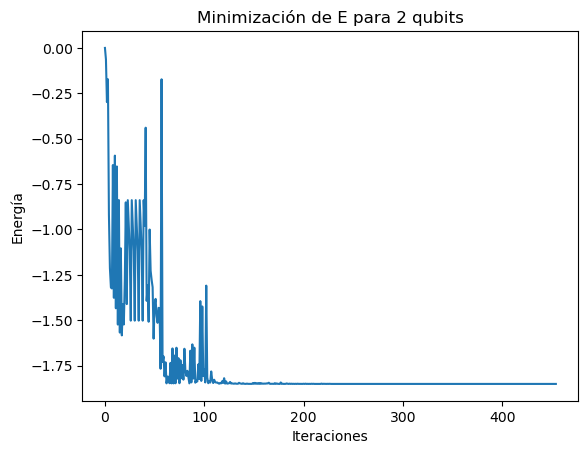

None

Fin optimización con 2 qubits. Energía: -1.8511991202843687

Preparando ejecución para 3 qubits.
Se usarán 90 parámetros


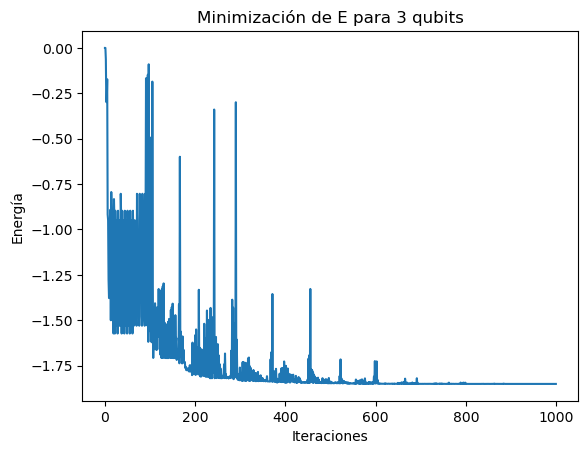

None

Fin optimización con 3 qubits. Energía: -1.8511989676375682

Preparando ejecución para 4 qubits.
Se usarán 160 parámetros


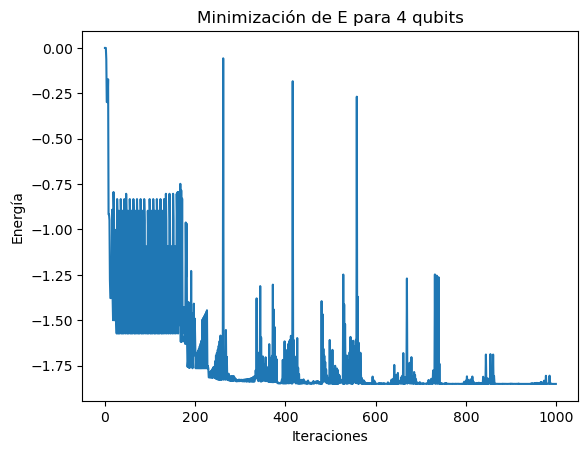

None

Fin optimización con 4 qubits. Energía: -1.8511940407785032

Preparando ejecución para 5 qubits.
Se usarán 250 parámetros


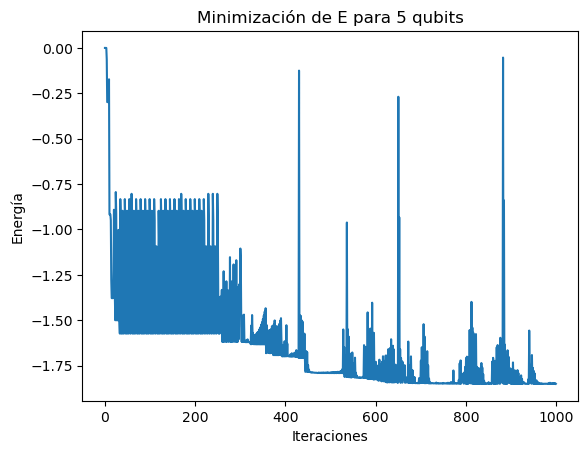

None

Fin optimización con 5 qubits. Energía: -1.8508377573591814

Preparando ejecución para 6 qubits.
Se usarán 360 parámetros


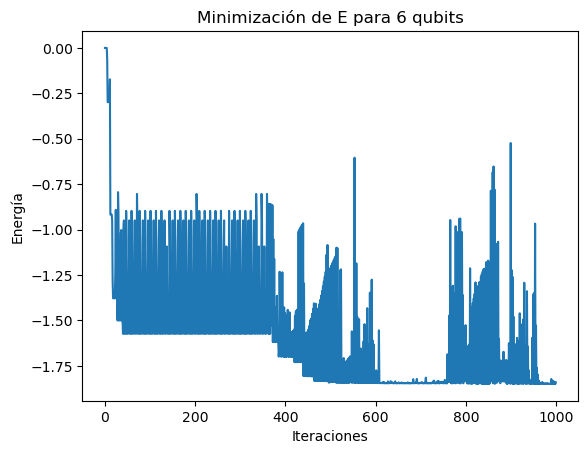

None

Fin optimización con 6 qubits. Energía: -1.8495152359947242

Preparando ejecución para 7 qubits.
Se usarán 490 parámetros


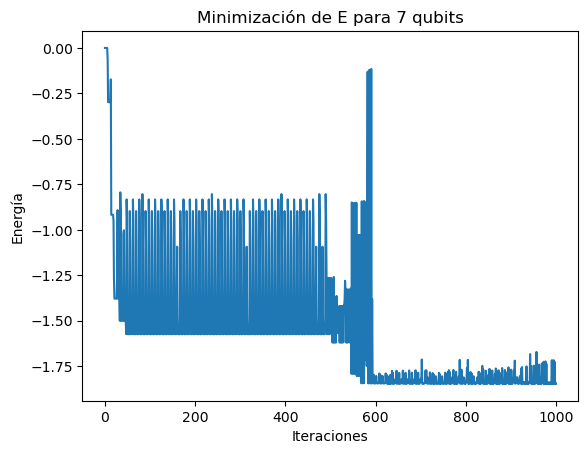

None

Fin optimización con 7 qubits. Energía: -1.8470668246342312

Preparando ejecución para 8 qubits.
Se usarán 640 parámetros


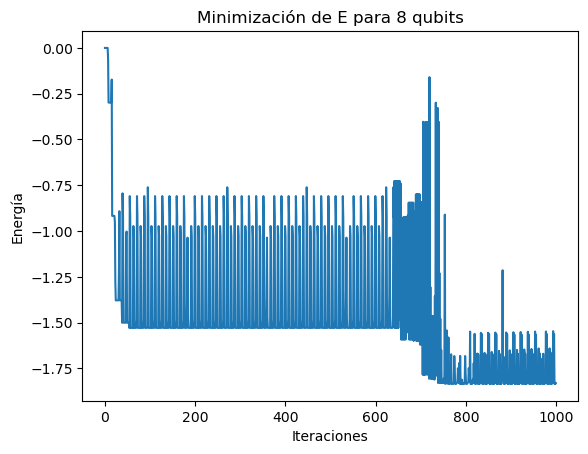

None

Fin optimización con 8 qubits. Energía: -1.8345289169678725

Preparando ejecución para 9 qubits.
Se usarán 810 parámetros


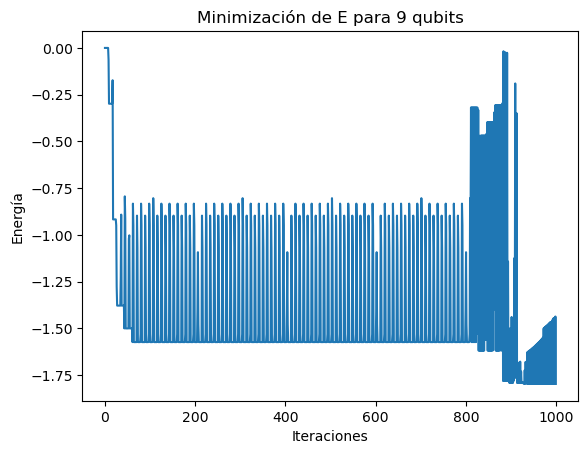

None

Fin optimización con 9 qubits. Energía: -1.7971147181619949

Preparando ejecución para 10 qubits.
Se usarán 1000 parámetros


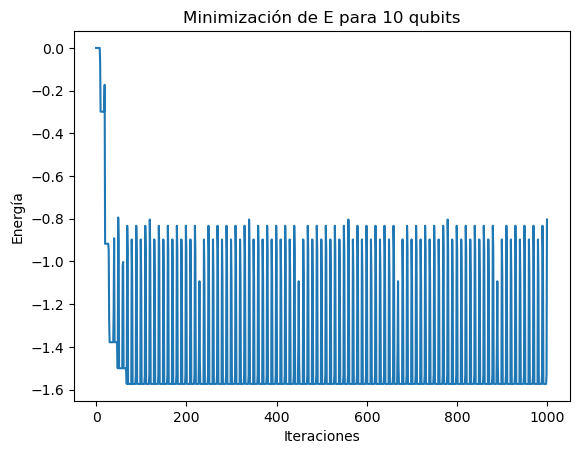

None

Fin optimización con 10 qubits. Energía: -1.5734333273552779


In [37]:
max_qubits = 10

# Creamos el estimador para el simulador
estimator = Estimator()

for i in range(2, max_qubits+1):
    
    current_hamiltonian=expand_hamiltonian(base_hamiltonian, i)
    ansatz_circuit, thetas = build_deep_ansatz(i)

    # Parámetros iniciales
    x0 = np.zeros(len(thetas)*i)

    # Información sobre la iteración actual
    print("\n=====================================================")
    print(f"Preparando ejecución para {i} qubits.")
    print(f"Se usarán {len(thetas)*i} parámetros")

    # Diccionario para almacenar la evolución del costo
    cost_history_dict = {
        "iters": 0,
        "cost_history": [],
    }

    def cost_func(params, ansatz, hamiltonian, estimator):
        job = estimator.run([ansatz], [hamiltonian], [params])
        result = job.result()
        energy = result.values[0]

        cost_history_dict["iters"] += 1
        cost_history_dict["cost_history"].append(energy)

        return energy

    # Ejecutamos la optimización
    res = minimize(
        cost_func,
        x0,
        args=(ansatz_circuit, current_hamiltonian, estimator),
        method="COBYLA",
    )

    # Graficar evolución del costo
    fig, ax = plt.subplots()
    ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
    ax.set_xlabel("Iteraciones")
    ax.set_ylabel("Energía")
    ax.set_title(f"VQE para {i} qubits")
    display(plt.show())

    print(f"Fin ejecución con {i} qubits. Energía: {res.fun}")
    print("=====================================================")


### Gráfica Var(E) vs nQubits


Calculando varianza de la energía con 2 qubits.

Calculando varianza de la energía con 3 qubits.

Calculando varianza de la energía con 4 qubits.

Calculando varianza de la energía con 5 qubits.

Calculando varianza de la energía con 6 qubits.

Calculando varianza de la energía con 7 qubits.

Calculando varianza de la energía con 8 qubits.

Calculando varianza de la energía con 9 qubits.

Calculando varianza de la energía con 10 qubits.

Calculando varianza de la energía con 11 qubits.

Calculando varianza de la energía con 12 qubits.

Calculando varianza de la energía con 13 qubits.

Calculando varianza de la energía con 14 qubits.

Calculando varianza de la energía con 15 qubits.


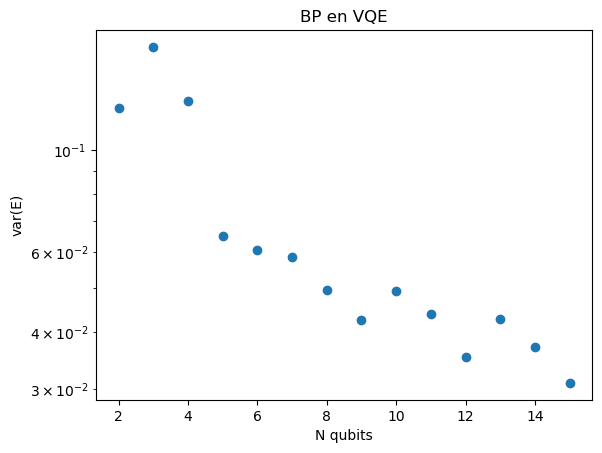

None

Fin ejecución con 15 qubits.


In [17]:
# Cuantos qubits usar
max_qubits = 15

# Cuantos valores de la funcion de costo probar para calcular la varianza
N = 50

# Datos que pintamos al final
data = []

# Creamos el estimador para el simulador
estimator = Estimator()

# Bucle número de qubits
for i in range(2, max_qubits+1):

    # Información sobre la iteración actual
    print("\n=====================================================")
    print(f"Calculando varianza de la energía con {i} qubits.")
    
    current_hamiltonian=expand_hamiltonian(base_hamiltonian, i)
    ansatz_circuit, thetas = build_deep_ansatz(i)

    def cost_func(params, ansatz, hamiltonian, estimator):
        job = estimator.run([ansatz], [hamiltonian], [params])
        result = job.result()
        energy = result.values[0]
        return energy

    # Lista para guardar los valores aleatorios
    random_energy = []

    for j in range(N+1):
        x0 = np.random.random(len(thetas)*i)
        random_energy.append(cost_func(x0, ansatz_circuit, current_hamiltonian, estimator))
    
    data.append([np.var(random_energy), i])
        
data = np.array(data)
# Graficar evolución del costo
fig, ax = plt.subplots()
ax.scatter(data[:,1], data[:,0])
ax.set_xlabel("N qubits")
ax.set_ylabel("var(E)")
ax.set_title(f"BP en VQE")
ax.set_yscale("log")
display(plt.show())

print(f"Fin ejecución con {i} qubits.")
print("=====================================================")

In [50]:
def grad(fun, x0, precision): # Calcula la derivada de la función en un punto x0.
    # fun -> función a la que se le saca el gradiente
    # x0 -> punto donde se saca el gradiente
    # precision -> incremento a utilizar
    
    # lista para guardar las derivadas
    grad = []

    # x0 contiene una lista de parametros
    for i in range(0, len(x0)): 
        x = x0
        x[i] += precision

        grad.append((fun(x)-fun(x0)/precision))

    return grad

        

def cuadrado(x):
    return x[0]*x[0]

grad(cuadrado, [1], 0.00001)



[-100000.99998999991]